## NN2 Model for Fair Value Estimation

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

df_NN2_Quintile_Signal = pd.DataFrame(index=list_company)
df_NN2_Decile_Signal = pd.DataFrame(index=list_company)
df_NN2_20_Divided_Signal = pd.DataFrame(index=list_company)
df_NN2_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # Baseline NN2 model
    model_nn2 = Sequential()
    model_nn2.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001), input_shape=(21,))) # Input layer
    model_nn2.add(Dropout(0.1))
    model_nn2.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 1
    model_nn2.add(Dropout(0.2))
    model_nn2.add(Dense(18, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 2
    model_nn2.add(Dropout(0.3))
    model_nn2.add(Dense(1, activation='linear')) # Output layer
    model_nn2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i+7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i+6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i+6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn2.fit(X_train, y_train, epochs=50, callbacks=[callback])
    y_fair = model_nn2.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_NN2_Quintile_Signal = df_NN2_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_NN2_Decile_Signal = df_NN2_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_NN2_20_Divided_Signal = df_NN2_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_NN2_Percentile_Signal = df_NN2_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

### (1) Performance Analysis

In [30]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_NN2_Quintile_Signal = pd.concat([df_199804_199809, df_NN2_Quintile_Signal, df_202206], axis=1)
df_NN2_Quintile_Signal = df_NN2_Quintile_Signal.fillna(0).T
df_NN2_Quintile_Signal = df_NN2_Quintile_Signal.shift(1).dropna()

df_NN2_Decile_Signal = pd.concat([df_199804_199809, df_NN2_Decile_Signal, df_202206], axis=1)
df_NN2_Decile_Signal = df_NN2_Decile_Signal.fillna(0).T
df_NN2_Decile_Signal = df_NN2_Decile_Signal.shift(1).dropna()

df_NN2_20_Divided_Signal = pd.concat([df_199804_199809, df_NN2_20_Divided_Signal, df_202206], axis=1)
df_NN2_20_Divided_Signal = df_NN2_20_Divided_Signal.fillna(0).T
df_NN2_20_Divided_Signal = df_NN2_20_Divided_Signal.shift(1).dropna()

df_NN2_Percentile_Signal = pd.concat([df_199804_199809, df_NN2_Percentile_Signal, df_202206], axis=1)
df_NN2_Percentile_Signal = df_NN2_Percentile_Signal.fillna(0).T
df_NN2_Percentile_Signal = df_NN2_Percentile_Signal.shift(1).dropna()

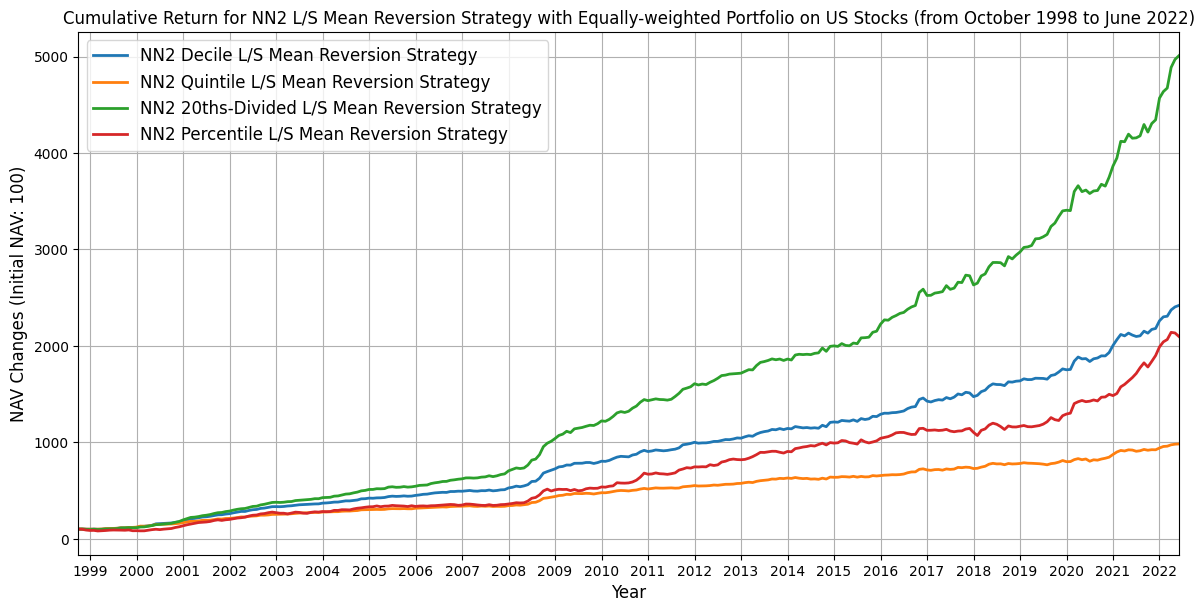

In [187]:
cum_NN2_Q_strategy_return = get_price_df(df_NN2_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_NN2_D_strategy_return = get_price_df(df_NN2_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_NN2_T_strategy_return = get_price_df(df_NN2_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_NN2_P_strategy_return = get_price_df(df_NN2_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_NN2_strategy_return = pd.concat([cum_NN2_D_strategy_return.rename('NN2 Decile L/S Mean Reversion Strategy'),
                                     cum_NN2_Q_strategy_return.rename('NN2 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN2_T_strategy_return.rename('NN2 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_NN2_P_strategy_return.rename('NN2 Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_NN2_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for NN2 L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)', fontsize=12)
plt.show()

In [224]:
# Performance Stats
stats_NN2_Q = get_performance_stats(cum_NN2_Q_strategy_return, rfr=risk_free_rate_df, label='NN2 Quintile (Initial NAV: 100)')
stats_NN2_D = get_performance_stats(cum_NN2_D_strategy_return, rfr=risk_free_rate_df, label='NN2 Decile (Initial NAV: 100)')
stats_NN2_T = get_performance_stats(cum_NN2_T_strategy_return, rfr=risk_free_rate_df, label='NN2 20ths (Initial NAV: 100)')
stats_NN2_P = get_performance_stats(cum_NN2_P_strategy_return, rfr=risk_free_rate_df, label='NN2 Percentile (Initial NAV: 100)')
NN2_stats = pd.concat([stats_NN2_Q, stats_NN2_D, stats_NN2_T, stats_NN2_P], axis=0)
display(NN2_stats)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN2 Quintile (Initial NAV: 100),10.388719,0.107856,0.018682,0.051103,1.744966,1.316263,4.626609,1138.871882,2022-06-30,0.043331,2018-10-31,2019-08-31,2019-12-31,426
NN2 Decile (Initial NAV: 100),25.364903,0.147711,0.018682,0.057262,2.253324,0.683546,3.337130,2636.490328,2022-06-30,0.023704,2021-05-31,2021-07-31,2021-09-30,122
NN2 20ths (Initial NAV: 100),47.490823,0.177539,0.018682,0.064869,2.448868,0.407527,3.884439,4849.082330,2022-06-30,0.033772,2017-12-31,2018-01-31,2018-04-30,120
NN2 Percentile (Initial NAV: 100),29.595633,0.154926,0.018682,0.095372,1.428553,-0.271155,4.006110,3059.563286,2022-06-30,0.078458,2015-03-31,2015-07-31,2016-03-31,366


In [225]:
stats2_NN2_Q = get_performance_stats_2(df_NN2_Quintile_Signal, df_returns, df_market_cap, label='NN2 Quintile', model_type='ML')
stats2_NN2_D = get_performance_stats_2(df_NN2_Decile_Signal, df_returns, df_market_cap, label='NN2 Decile', model_type='ML')
stats2_NN2_T = get_performance_stats_2(df_NN2_20_Divided_Signal, df_returns, df_market_cap, label='NN2 20ths', model_type='ML')
stats2_NN2_P = get_performance_stats_2(df_NN2_Percentile_Signal, df_returns, df_market_cap, label='NN2 Percentile', model_type='ML')
NN2_stats2 = pd.concat([stats2_NN2_Q, stats2_NN2_D, stats2_NN2_T, stats2_NN2_P], axis=0)
display(NN2_stats2)

,Total Return,Avg Monthly Return,Avg Mkt Cap,Fraction>0,+ Return Stocks (Avg),- Return Stocks (Avg),Odds Ratio,Odds Ratio 98-10,Odds Ratio 11-22,Transactions/Month
NN2 Quintile (Long & Short),10.388719,0.008572,3.251328e+10,0.689655,0.090975,-0.076935,0.506494,0.521331,0.493993,464.286207
(Long Position),1118.202751,0.024939,1.655647e+09,0.706897,0.102203,-0.073423,0.568652,0.589135,0.551642,226.924138
(Short Position),-0.941133,-0.009889,6.108494e+10,0.379310,0.063942,-0.070457,0.449196,0.459767,0.440170,243.268966
NN2 Decile (Long & Short),25.364903,0.011547,4.900787e+10,0.755172,0.090896,-0.073278,0.517024,0.536302,0.500915,325.862069
(Long Position),5984.259183,0.030986,1.586582e+09,0.741379,0.102509,-0.065785,0.592038,0.621103,0.568307,160.217241
(Short Position),-0.939122,-0.009773,9.109792e+10,0.358621,0.063921,-0.070643,0.450873,0.463281,0.440290,167.031034
NN2 20ths (Long & Short),47.490823,0.013712,7.626550e+10,0.813793,0.091032,-0.071057,0.529819,0.549121,0.513712,208.289655
(Long Position),27148.992820,0.036471,1.853399e+09,0.793103,0.101702,-0.057134,0.624840,0.659283,0.596830,109.027586
(Short Position),-0.956241,-0.010919,1.391976e+11,0.365517,0.064808,-0.072041,0.450385,0.459382,0.442713,99.606897
NN2 Percentile (Long & Short),29.595633,0.012075,2.321746e+11,0.662069,0.092001,-0.078940,0.543466,0.551510,0.536507,52.503448


In [52]:
cum_NN2_Q_strategy_return_L = get_price_df(df_NN2_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN2_Q_strategy_return_S = get_price_df(df_NN2_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_NN2_D_strategy_return_L = get_price_df(df_NN2_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN2_D_strategy_return_S = get_price_df(df_NN2_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_NN2_Q_L = get_performance_stats(cum_NN2_Q_strategy_return_L, rfr=risk_free_rate_df, label='NN2 Quintile L (Initial NAV: 100)')
stats_NN2_Q_S = get_performance_stats(cum_NN2_Q_strategy_return_S, rfr=risk_free_rate_df, label='NN2 Quintile S (Initial NAV: 100)')
stats_NN2_D_L = get_performance_stats(cum_NN2_D_strategy_return_L, rfr=risk_free_rate_df, label='NN2 Decile L (Initial NAV: 100)')
stats_NN2_D_S = get_performance_stats(cum_NN2_D_strategy_return_S, rfr=risk_free_rate_df, label='NN2 Decile S (Initial NAV: 100)')
NN2_stats3 = pd.concat([stats_NN2_Q_L, stats_NN2_Q_S, stats_NN2_D_L, stats_NN2_D_S], axis=0)
display(NN2_stats3)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN2 Quintile L (Initial NAV: 100),1034.480015,0.339533,0.018682,0.172441,1.860633,0.628231,1.923804,118756.615068,2021-10-31,0.128065,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN2 Quintile S (Initial NAV: 100),9.693873,0.104923,0.018682,0.167968,0.513435,-0.471199,1.312503,1417.557242,2021-10-31,0.245613,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN2 Decile L (Initial NAV: 100),6069.853551,0.443094,0.018682,0.161156,2.633543,0.983680,2.668089,660477.835481,2022-03-31,0.080839,2022-03-31,2022-06-30,Yet to recover,Yet to recover
NN2 Decile S (Initial NAV: 100),8.883623,0.101263,0.018682,0.170758,0.483613,-0.461024,1.356909,1359.216662,2021-10-31,0.272844,2021-10-31,2022-06-30,Yet to recover,Yet to recover


### (2) Hyperparameters Tuning

In [66]:
validation_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]

X_temp = X[X.datadate.isin(validation_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_validation = X_norm[X_norm.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]

y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [67]:
def creating_nn2(hp):
    model = Sequential()

    unit1 = hp.Int('Input_layer',min_value=1, max_value = 21, step = 1)
    unit2 = hp.Int('lay1',min_value=1, max_value = 21, step = 1)
    unit3 = hp.Int('lay2',min_value=1, max_value = 21, step = 1)
    unit4 = hp.Float('dropout1', min_value=0, max_value=0.7, step=0.1)
    unit5 = hp.Float('dropout2', min_value=0, max_value=0.7, step=0.1)
    unit6 = hp.Float('dropout3', min_value=0, max_value=0.7, step=0.1)
    unit7 = hp.Choice('regularization', values = [1e-1, 1e-2, 1e-3])
    unit8 = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')
    learning_rate1  = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])


    model.add(Dense(unit1, activation=unit8, kernel_regularizer=regularizers.l2(unit7), bias_regularizer=regularizers.l2(unit7), input_shape=(21,)))
    model.add(Dropout(unit4))
    model.add(Dense(unit2, activation=unit8, kernel_regularizer=regularizers.l2(unit7), bias_regularizer=regularizers.l2(unit7)))
    model.add(Dropout(unit5))
    model.add(Dense(unit3, activation=unit8, kernel_regularizer=regularizers.l2(unit7), bias_regularizer=regularizers.l2(unit7)))
    model.add(Dropout(unit6))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate1), loss='mse', metrics=['mae'])

    return model

In [ ]:
tuner_nn2 = kt.Hyperband(creating_nn2, objective='val_loss', max_epochs=50, project_name='nn2_tuning_1', overwrite=True)
tuner_nn2.search(X_validation, y_validation, epochs=50, validation_data=(X_validation, y_validation), callbacks=[callback], batch_size=32)

In [ ]:
tuner_nn2.results_summary()

In [ ]:
"""
Hyperparameters:
Input_layer: 15
lay1: 4
lay2: 18
dropout1: 0.1
dropout2: 0.2
dropout3: 0.3
regularization: 0.001
dense_activation: relu
learning_rate: 0.01
tuner/epochs: 50
"""

### (3) Feature Importance

In [ ]:
model_nn2 = Sequential()
model_nn2.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001), input_shape=(21,))) # Input layer
model_nn2.add(Dropout(0.1))
model_nn2.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 1
model_nn2.add(Dropout(0.2))
model_nn2.add(Dense(18, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 2
model_nn2.add(Dropout(0.3))
model_nn2.add(Dense(1, activation='linear')) # Output layer
model_nn2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

temp_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10']
train_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']
test_date = ['1998-10']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

X_temp = X[X.datadate.isin(temp_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_train = X_norm[X_norm.datadate.isin(train_date)]
X_train = X_train.iloc[:, 2:]
X_train = np.array(X_train)

y_train = y[y.datadate.isin(train_date)]
y_train = y_train.iloc[:, 2]
y_train = np.array(y_train)

X_test = X_norm[X_norm.datadate.isin(test_date)]
X_test = X_test.iloc[:, 2:]
X_test = np.array(X_test)

y_test = y[y.datadate.isin(test_date)]
y_test = y_test.iloc[:, 2]
y_test = np.array(y_test)

model_nn2.fit(X_train, y_train)

perm_nn2 = PermutationImportance(model_nn2, scoring='neg_mean_squared_error', random_state=random_state).fit(X_test, y_test)
nn2_importances_1 = pd.Series(perm_nn2.feature_importances_, index=feature_names).sort_values(ascending=False)

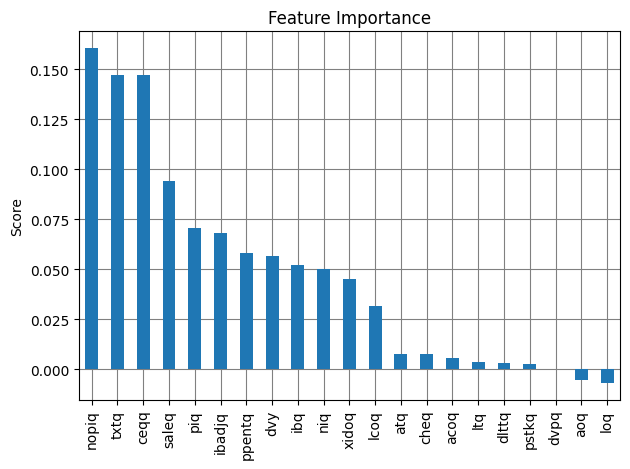

In [376]:
nn2 = nn2_importances_1 /(nn2_importances_1.sum())
fig, ax2 = plt.subplots()
nn2.plot.bar(ax=ax2)
ax2.set_axisbelow(True)
ax2.grid(color='gray')
ax2.set_title('Feature Importance')
ax2.set_ylabel('Score')
fig.tight_layout()
plt.show()

## NN3 Model for Fair Value Estimation

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

df_NN3_Quintile_Signal = pd.DataFrame(index=list_company)
df_NN3_Decile_Signal = pd.DataFrame(index=list_company)
df_NN3_20_Divided_Signal = pd.DataFrame(index=list_company)
df_NN3_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # Baseline NN3 model
    model_nn3 = Sequential()
    model_nn3.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1), input_shape=(21,))) # Input layer
    model_nn3.add(Dropout(0.2))
    model_nn3.add(Dense(13, activation='relu', kernel_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1))) # hidden layer 1
    model_nn3.add(Dropout(0.2))
    model_nn3.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1))) # hidden layer 2
    model_nn3.add(Dropout(0.1))
    model_nn3.add(Dense(17, activation='relu', kernel_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1))) # hidden layer 2
    model_nn3.add(Dropout(0))
    model_nn3.add(Dense(1, activation='linear')) # Output layer
    model_nn3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i+7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i+6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i+6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn3.fit(X_train, y_train, epochs=50, callbacks=[callback])
    y_fair = model_nn3.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_NN3_Quintile_Signal = df_NN3_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_NN3_Decile_Signal = df_NN3_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_NN3_20_Divided_Signal = df_NN3_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_NN3_Percentile_Signal = df_NN3_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

### (1) Performance Analysis

In [33]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_NN3_Quintile_Signal = pd.concat([df_199804_199809, df_NN3_Quintile_Signal, df_202206], axis=1)
df_NN3_Quintile_Signal = df_NN3_Quintile_Signal.fillna(0).T
df_NN3_Quintile_Signal = df_NN3_Quintile_Signal.shift(1).dropna()

df_NN3_Decile_Signal = pd.concat([df_199804_199809, df_NN3_Decile_Signal, df_202206], axis=1)
df_NN3_Decile_Signal = df_NN3_Decile_Signal.fillna(0).T
df_NN3_Decile_Signal = df_NN3_Decile_Signal.shift(1).dropna()

df_NN3_20_Divided_Signal = pd.concat([df_199804_199809, df_NN3_20_Divided_Signal, df_202206], axis=1)
df_NN3_20_Divided_Signal = df_NN3_20_Divided_Signal.fillna(0).T
df_NN3_20_Divided_Signal = df_NN3_20_Divided_Signal.shift(1).dropna()

df_NN3_Percentile_Signal = pd.concat([df_199804_199809, df_NN3_Percentile_Signal, df_202206], axis=1)
df_NN3_Percentile_Signal = df_NN3_Percentile_Signal.fillna(0).T
df_NN3_Percentile_Signal = df_NN3_Percentile_Signal.shift(1).dropna()

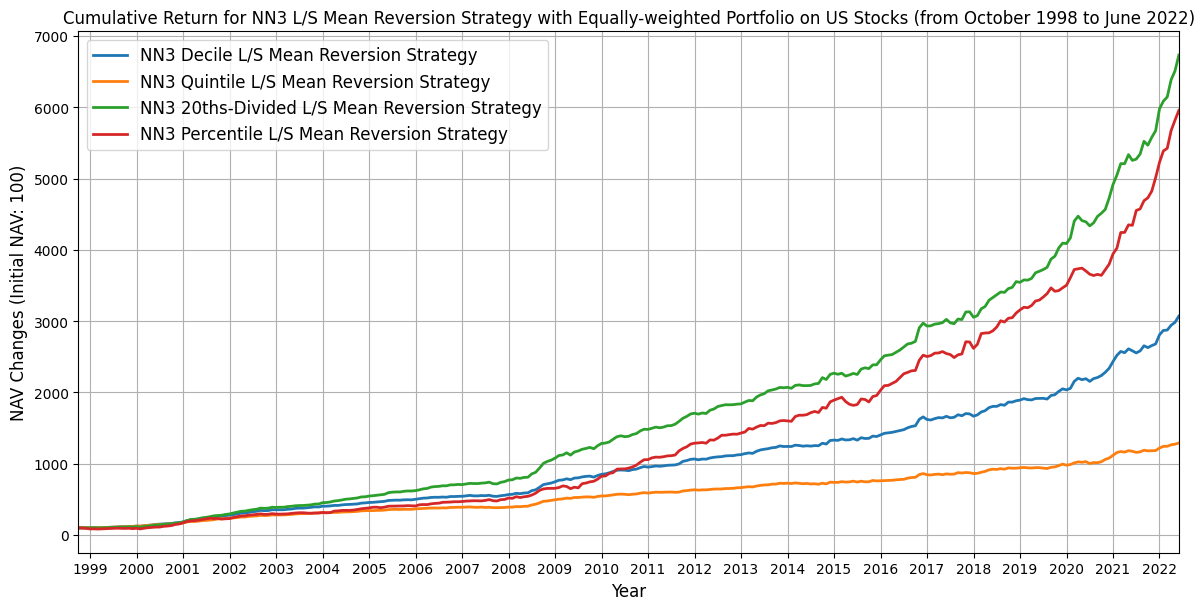

In [188]:
cum_NN3_Q_strategy_return = get_price_df(df_NN3_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_NN3_D_strategy_return = get_price_df(df_NN3_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_NN3_T_strategy_return = get_price_df(df_NN3_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_NN3_P_strategy_return = get_price_df(df_NN3_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_NN3_strategy_return = pd.concat([cum_NN3_D_strategy_return.rename('NN3 Decile L/S Mean Reversion Strategy'),
                                     cum_NN3_Q_strategy_return.rename('NN3 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN3_T_strategy_return.rename('NN3 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_NN3_P_strategy_return.rename('NN3 Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_NN3_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for NN3 L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)', fontsize=12)
plt.show()

In [226]:
# Performance Stats
stats_NN3_Q = get_performance_stats(cum_NN3_Q_strategy_return, rfr=risk_free_rate_df, label='NN3 Quintile (Initial NAV: 100)')
stats_NN3_D = get_performance_stats(cum_NN3_D_strategy_return, rfr=risk_free_rate_df, label='NN3 Decile (Initial NAV: 100)')
stats_NN3_T = get_performance_stats(cum_NN3_T_strategy_return, rfr=risk_free_rate_df, label='NN3 20ths (Initial NAV: 100)')
stats_NN3_P = get_performance_stats(cum_NN3_P_strategy_return, rfr=risk_free_rate_df, label='NN3 Percentile (Initial NAV: 100)')
NN3_stats = pd.concat([stats_NN3_Q, stats_NN3_D, stats_NN3_T, stats_NN3_P], axis=0)
display(NN3_stats)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN3 Quintile (Initial NAV: 100),10.972314,0.110189,0.018682,0.050041,1.828627,0.834326,1.347156,1197.231356,2022-06-30,0.026859,2020-06-30,2020-07-31,2020-10-31,123
NN3 Decile (Initial NAV: 100),30.093040,0.155710,0.018682,0.058478,2.343220,0.905921,1.822998,3109.304005,2022-06-30,0.028855,2021-05-31,2021-07-31,2021-11-30,183
NN3 20ths (Initial NAV: 100),72.639271,0.198437,0.018682,0.068284,2.632460,0.786990,2.888233,7363.927076,2022-06-30,0.023392,2021-05-31,2021-07-31,2021-09-30,122
NN3 Percentile (Initial NAV: 100),46.942264,0.176975,0.018682,0.096788,1.635446,-0.034056,2.962242,4794.226423,2022-06-30,0.045831,2020-03-31,2020-08-31,2020-12-31,275


In [227]:
stats2_NN3_Q = get_performance_stats_2(df_NN3_Quintile_Signal, df_returns, df_market_cap, label='NN3 Quintile', model_type='ML')
stats2_NN3_D = get_performance_stats_2(df_NN3_Decile_Signal, df_returns, df_market_cap, label='NN3 Decile', model_type='ML')
stats2_NN3_T = get_performance_stats_2(df_NN3_20_Divided_Signal, df_returns, df_market_cap, label='NN3 20ths', model_type='ML')
stats2_NN3_P = get_performance_stats_2(df_NN3_Percentile_Signal, df_returns, df_market_cap, label='NN3 Percentile', model_type='ML')
NN3_stats2 = pd.concat([stats2_NN3_Q, stats2_NN3_D, stats2_NN3_T, stats2_NN3_P], axis=0)
display(NN3_stats2)

,Total Return,Avg Monthly Return,Avg Mkt Cap,Fraction>0,+ Return Stocks (Avg),- Return Stocks (Avg),Odds Ratio,Odds Ratio 98-10,Odds Ratio 11-22,Transactions/Month
NN3 Quintile (Long & Short),10.972314,0.008749,3.277610e+10,0.713793,0.091682,-0.077366,0.507571,0.520802,0.496437,408.686207
(Long Position),1311.086156,0.025511,1.105542e+09,0.703448,0.103030,-0.073202,0.569466,0.588317,0.553847,187.710345
(Short Position),-0.945341,-0.010147,6.202225e+10,0.379310,0.064674,-0.071379,0.450701,0.459761,0.442969,224.931034
NN3 Decile (Long & Short),30.093040,0.012133,4.936544e+10,0.762069,0.092555,-0.073973,0.519506,0.537226,0.504721,295.706897
(Long Position),9000.009826,0.032463,1.056606e+09,0.751724,0.103767,-0.065201,0.595738,0.625358,0.571645,138.451724
(Short Position),-0.947396,-0.010280,9.187197e+10,0.393103,0.065275,-0.071947,0.452815,0.462102,0.444893,158.148276
NN3 20ths (Long & Short),72.639271,0.015199,7.863899e+10,0.800000,0.093000,-0.071051,0.535243,0.558743,0.515690,192.100000
(Long Position),55661.240658,0.039085,1.305014e+09,0.817241,0.103067,-0.054960,0.634114,0.675958,0.600282,99.958621
(Short Position),-0.954311,-0.010769,1.426163e+11,0.379310,0.066499,-0.073605,0.453898,0.465021,0.444422,92.496552
NN3 Percentile (Long & Short),46.942264,0.013672,2.356793e+11,0.737931,0.091445,-0.078529,0.558481,0.564493,0.553156,51.068966


In [53]:
cum_NN3_Q_strategy_return_L = get_price_df(df_NN3_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN3_Q_strategy_return_S = get_price_df(df_NN3_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_NN3_D_strategy_return_L = get_price_df(df_NN3_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN3_D_strategy_return_S = get_price_df(df_NN3_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_NN3_Q_L = get_performance_stats(cum_NN3_Q_strategy_return_L, rfr=risk_free_rate_df, label='NN3 Quintile L (Initial NAV: 100)')
stats_NN3_Q_S = get_performance_stats(cum_NN3_Q_strategy_return_S, rfr=risk_free_rate_df, label='NN3 Quintile S (Initial NAV: 100)')
stats_NN3_D_L = get_performance_stats(cum_NN3_D_strategy_return_L, rfr=risk_free_rate_df, label='NN3 Decile L (Initial NAV: 100)')
stats_NN3_D_S = get_performance_stats(cum_NN3_D_strategy_return_S, rfr=risk_free_rate_df, label='NN3 Decile S (Initial NAV: 100)')
NN3_stats3 = pd.concat([stats_NN3_Q_L, stats_NN3_Q_S, stats_NN3_D_L, stats_NN3_D_S], axis=0)
display(NN3_stats3)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN3 Quintile L (Initial NAV: 100),1328.453456,0.353702,0.018682,0.168617,1.986863,0.359533,0.531813,148544.423494,2021-10-31,0.105013,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN3 Quintile S (Initial NAV: 100),6.873907,0.090773,0.018682,0.169086,0.426353,-0.467468,1.276788,1064.147202,2021-08-31,0.260074,2021-08-31,2022-06-30,Yet to recover,Yet to recover
NN3 Decile L (Initial NAV: 100),7098.941888,0.452640,0.018682,0.156629,2.770611,0.586410,0.901572,756542.409932,2022-03-31,0.061528,2022-03-31,2022-06-30,Yet to recover,Yet to recover
NN3 Decile S (Initial NAV: 100),5.918770,0.084850,0.018682,0.177353,0.373084,-0.408330,1.599747,996.370439,2021-08-31,0.305603,2021-08-31,2022-06-30,Yet to recover,Yet to recover


### (2) Hyperparameters Tuning

In [48]:
validation_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]


X_temp = X[X.datadate.isin(validation_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_validation = X_norm[X_norm.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]
X_validation = np.array(X_validation)

y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]
y_validation = np.array(y_validation)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [49]:
def creating_nn3(hp):
    model = Sequential()

    unit1 = hp.Int('Input_layer',min_value=1, max_value = 21, step = 1)
    unit2 = hp.Int('lay1',min_value=1, max_value = 21, step = 1)
    unit3 = hp.Int('lay2',min_value=1, max_value = 21, step = 1)
    unit4 = hp.Int('lay3',min_value=1, max_value = 21, step = 1)
    unit5 = hp.Float('dropout1', min_value=0, max_value=0.7, step=0.1)
    unit6 = hp.Float('dropout2', min_value=0, max_value=0.7, step=0.1)
    unit7 = hp.Float('dropout3', min_value=0, max_value=0.7, step=0.1)
    unit8 = hp.Float('dropout4', min_value=0, max_value=0.7, step=0.1)
    unit9 = hp.Choice('regularization', values = [1e-1, 1e-2, 1e-3])
    unit10 = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')
    learning_rate1  = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])


    model.add(Dense(unit1, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9), input_shape=(21,)))
    model.add(Dropout(unit5))
    model.add(Dense(unit2, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit6))
    model.add(Dense(unit3, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit7))
    model.add(Dense(unit4, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit8))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate1), loss='mse', metrics=['mae'])

    return model

In [ ]:
tuner_nn3 = kt.Hyperband(creating_nn3, objective='val_loss', max_epochs=50, project_name='nn3_tuning_1', overwrite=True)
tuner_nn3.search(X_validation, y_validation, epochs=50, validation_data=(X_validation, y_validation), callbacks=[callback], batch_size=32)

In [ ]:
tuner_nn3.results_summary()

In [ ]:
"""
Hyperparameters:
Input_layer: 20
lay1: 13
lay2: 11
lay3: 17
dropout1: 0.2
dropout2: 0.2
dropout3: 0.1
dropout4: 0
regularization: 0.1
dense_activation: relu
learning_rate: 0.01
tuner/epochs: 50
"""

### (3) Feature Importance

In [ ]:
model_nn3 = Sequential()
model_nn3.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1), input_shape=(21,))) # Input layer
model_nn3.add(Dropout(0.2))
model_nn3.add(Dense(13, activation='relu', kernel_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1))) # hidden layer 1
model_nn3.add(Dropout(0.2))
model_nn3.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1))) # hidden layer 2
model_nn3.add(Dropout(0.1))
model_nn3.add(Dense(17, activation='relu', kernel_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1))) # hidden layer 2
model_nn3.add(Dropout(0))
model_nn3.add(Dense(1, activation='linear')) # Output layer
model_nn3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

temp_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10']
train_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']
test_date = ['1998-10']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

X_temp = X[X.datadate.isin(temp_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_train = X_norm[X_norm.datadate.isin(train_date)]
X_train = X_train.iloc[:, 2:]
X_train = np.array(X_train)

y_train = y[y.datadate.isin(train_date)]
y_train = y_train.iloc[:, 2]
y_train = np.array(y_train)

X_test = X_norm[X_norm.datadate.isin(test_date)]
X_test = X_test.iloc[:, 2:]
X_test = np.array(X_test)

y_test = y[y.datadate.isin(test_date)]
y_test = y_test.iloc[:, 2]
y_test = np.array(y_test)

model_nn3.fit(X_train, y_train)

perm_nn3 = PermutationImportance(model_nn3, scoring='neg_mean_squared_error', random_state=random_state).fit(X_test, y_test)
nn3_importances_1 = pd.Series(perm_nn3.feature_importances_, index=feature_names).sort_values(ascending=False)

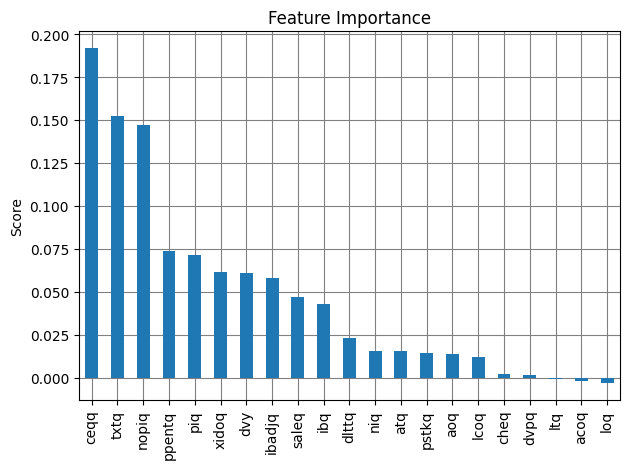

In [379]:
nn3 = nn3_importances_1 /(nn3_importances_1.sum())
fig, ax3 = plt.subplots()
nn3.plot.bar(ax=ax3)
ax3.set_axisbelow(True)
ax3.grid(color='gray')
ax3.set_title('Feature Importance')
ax3.set_ylabel('Score')
fig.tight_layout()
plt.show()

## 6. NN4 Model for Fair Value Estimation

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

df_NN4_Quintile_Signal = pd.DataFrame(index=list_company)
df_NN4_Decile_Signal = pd.DataFrame(index=list_company)
df_NN4_20_Divided_Signal = pd.DataFrame(index=list_company)
df_NN4_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # Baseline NN4 model
    model_nn4 = Sequential()
    model_nn4.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), input_shape=(21,))) # Input layer
    model_nn4.add(Dropout(0.3))
    model_nn4.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 1
    model_nn4.add(Dropout(0.3))
    model_nn4.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 2
    model_nn4.add(Dropout(0.4))
    model_nn4.add(Dense(17, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 3
    model_nn4.add(Dropout(0.4))
    model_nn4.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 4
    model_nn4.add(Dropout(0.1))
    model_nn4.add(Dense(1, activation='linear')) # Output layer
    model_nn4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i+7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i+6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i+6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn4.fit(X_train, y_train, epochs=2, callbacks=[callback])
    y_fair = model_nn4.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_NN4_Quintile_Signal = df_NN4_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_NN4_Decile_Signal = df_NN4_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_NN4_20_Divided_Signal = df_NN4_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_NN4_Percentile_Signal = df_NN4_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

### (1) Performance Analysis

In [36]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_NN4_Quintile_Signal = pd.concat([df_199804_199809, df_NN4_Quintile_Signal, df_202206], axis=1)
df_NN4_Quintile_Signal = df_NN4_Quintile_Signal.fillna(0).T
df_NN4_Quintile_Signal = df_NN4_Quintile_Signal.shift(1).dropna()

df_NN4_Decile_Signal = pd.concat([df_199804_199809, df_NN4_Decile_Signal, df_202206], axis=1)
df_NN4_Decile_Signal = df_NN4_Decile_Signal.fillna(0).T
df_NN4_Decile_Signal = df_NN4_Decile_Signal.shift(1).dropna()

df_NN4_20_Divided_Signal = pd.concat([df_199804_199809, df_NN4_20_Divided_Signal, df_202206], axis=1)
df_NN4_20_Divided_Signal = df_NN4_20_Divided_Signal.fillna(0).T
df_NN4_20_Divided_Signal = df_NN4_20_Divided_Signal.shift(1).dropna()

df_NN4_Percentile_Signal = pd.concat([df_199804_199809, df_NN4_Percentile_Signal, df_202206], axis=1)
df_NN4_Percentile_Signal = df_NN4_Percentile_Signal.fillna(0).T
df_NN4_Percentile_Signal = df_NN4_Percentile_Signal.shift(1).dropna()

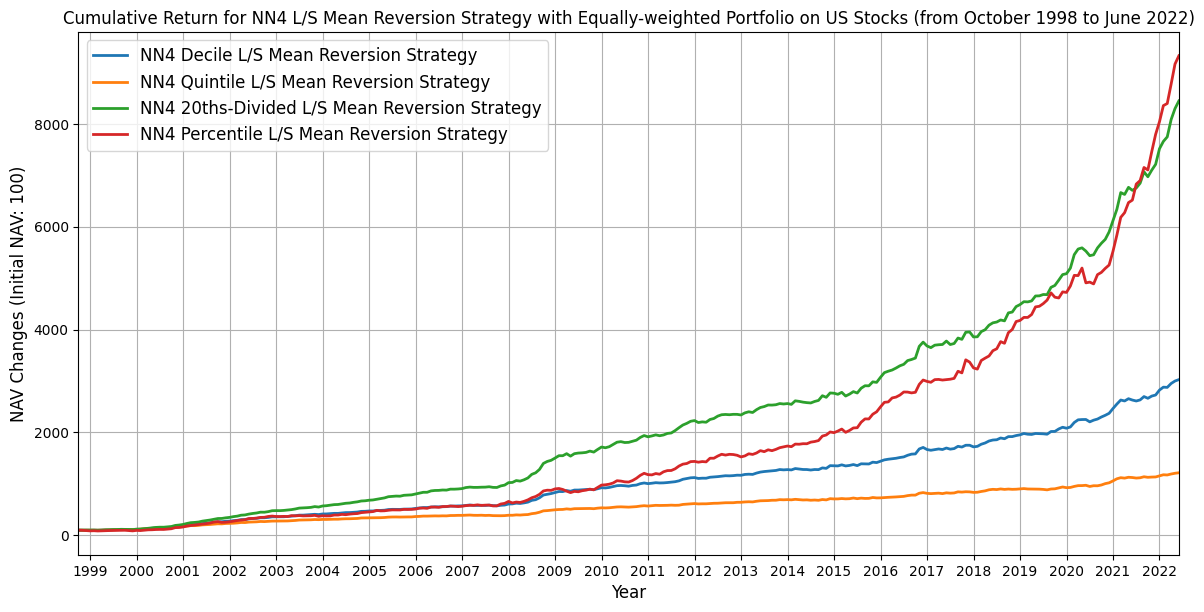

In [189]:
cum_NN4_Q_strategy_return = get_price_df(df_NN4_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_NN4_D_strategy_return = get_price_df(df_NN4_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_NN4_T_strategy_return = get_price_df(df_NN4_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_NN4_P_strategy_return = get_price_df(df_NN4_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_NN4_strategy_return = pd.concat([cum_NN4_D_strategy_return.rename('NN4 Decile L/S Mean Reversion Strategy'),
                                     cum_NN4_Q_strategy_return.rename('NN4 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN4_T_strategy_return.rename('NN4 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_NN4_P_strategy_return.rename('NN4 Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_NN4_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for NN4 L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)', fontsize=12)
plt.show()

In [228]:
# Performance Stats
stats_NN4_Q = get_performance_stats(cum_NN4_Q_strategy_return, rfr=risk_free_rate_df, label='NN4 Quintile (Initial NAV: 100)')
stats_NN4_D = get_performance_stats(cum_NN4_D_strategy_return, rfr=risk_free_rate_df, label='NN4 Decile (Initial NAV: 100)')
stats_NN4_T = get_performance_stats(cum_NN4_T_strategy_return, rfr=risk_free_rate_df, label='NN4 20ths (Initial NAV: 100)')
stats_NN4_P = get_performance_stats(cum_NN4_P_strategy_return, rfr=risk_free_rate_df, label='NN4 Percentile (Initial NAV: 100)')
NN4_stats = pd.concat([stats_NN4_Q, stats_NN4_D, stats_NN4_T, stats_NN4_P], axis=0)
display(NN4_stats)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN4 Quintile (Initial NAV: 100),11.073966,0.110584,0.018682,0.049570,1.853966,0.886015,1.350419,1207.396572,2022-06-30,0.028728,2019-02-28,2019-08-31,2019-11-30,275
NN4 Decile (Initial NAV: 100),29.592416,0.154921,0.018682,0.061530,2.214166,0.971289,1.804169,3059.241598,2022-06-30,0.034363,2020-04-30,2020-07-31,2020-10-31,184
NN4 20ths (Initial NAV: 100),90.562877,0.209480,0.018682,0.071539,2.667041,0.943901,1.863831,9156.287657,2022-06-30,0.029582,2020-04-30,2020-07-31,2020-10-31,184
NN4 Percentile (Initial NAV: 100),120.682577,0.224050,0.018682,0.096405,2.130257,0.174948,0.862964,12168.257663,2022-06-30,0.045187,2020-03-31,2020-06-30,2020-09-30,183


In [229]:
stats2_NN4_Q = get_performance_stats_2(df_NN4_Quintile_Signal, df_returns, df_market_cap, label='NN4 Quintile', model_type='ML')
stats2_NN4_D = get_performance_stats_2(df_NN4_Decile_Signal, df_returns, df_market_cap, label='NN4 Decile', model_type='ML')
stats2_NN4_T = get_performance_stats_2(df_NN4_20_Divided_Signal, df_returns, df_market_cap, label='NN4 20ths', model_type='ML')
stats2_NN4_P = get_performance_stats_2(df_NN4_Percentile_Signal, df_returns, df_market_cap, label='NN4 Percentile', model_type='ML')
NN4_stats2 = pd.concat([stats2_NN4_Q, stats2_NN4_D, stats2_NN4_T, stats2_NN4_P], axis=0)
display(NN4_stats2)

,Total Return,Avg Monthly Return,Avg Mkt Cap,Fraction>0,+ Return Stocks (Avg),- Return Stocks (Avg),Odds Ratio,Odds Ratio 98-10,Odds Ratio 11-22,Transactions/Month
NN4 Quintile (Long & Short),11.073966,0.008779,3.549626e+10,0.710345,0.092117,-0.077589,0.506937,0.521510,0.494674,310.058621
(Long Position),1319.789306,0.025535,7.176343e+08,0.710345,0.103175,-0.073395,0.569542,0.589480,0.553032,148.082759
(Short Position),-0.944813,-0.010114,6.758440e+10,0.372414,0.065184,-0.071630,0.449454,0.460133,0.440335,162.331034
NN4 Decile (Long & Short),29.592416,0.012075,6.021679e+10,0.744828,0.092874,-0.074339,0.519359,0.538336,0.503573,224.675862
(Long Position),8912.793250,0.032428,5.763279e+08,0.748276,0.103491,-0.064066,0.594950,0.628187,0.568093,113.610345
(Short Position),-0.947923,-0.010315,1.124679e+11,0.393103,0.066146,-0.073100,0.453556,0.462406,0.446006,111.113793
NN4 20ths (Long & Short),90.562877,0.015975,1.037590e+11,0.782759,0.093798,-0.071350,0.539662,0.562907,0.520561,150.010345
(Long Position),88805.359640,0.040790,6.013138e+08,0.837931,0.103729,-0.051928,0.641832,0.693816,0.600975,85.303448
(Short Position),-0.955461,-0.010858,1.878496e+11,0.393103,0.067432,-0.075255,0.456963,0.461527,0.453076,64.710345
NN4 Percentile (Long & Short),120.682577,0.016990,3.446433e+11,0.737931,0.093344,-0.077177,0.578313,0.580282,0.576616,44.951724


In [54]:
cum_NN4_Q_strategy_return_L = get_price_df(df_NN4_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN4_Q_strategy_return_S = get_price_df(df_NN4_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_NN4_D_strategy_return_L = get_price_df(df_NN4_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN4_D_strategy_return_S = get_price_df(df_NN4_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_NN4_Q_L = get_performance_stats(cum_NN4_Q_strategy_return_L, rfr=risk_free_rate_df, label='NN4 Quintile L (Initial NAV: 100)')
stats_NN4_Q_S = get_performance_stats(cum_NN4_Q_strategy_return_S, rfr=risk_free_rate_df, label='NN4 Quintile S (Initial NAV: 100)')
stats_NN4_D_L = get_performance_stats(cum_NN4_D_strategy_return_L, rfr=risk_free_rate_df, label='NN4 Decile L (Initial NAV: 100)')
stats_NN4_D_S = get_performance_stats(cum_NN4_D_strategy_return_S, rfr=risk_free_rate_df, label='NN4 Decile S (Initial NAV: 100)')
NN4_stats3 = pd.concat([stats_NN4_Q_L, stats_NN4_Q_S, stats_NN4_D_L, stats_NN4_D_S], axis=0)
display(NN4_stats3)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN4 Quintile L (Initial NAV: 100),1290.207151,0.352039,0.018682,0.168721,1.975784,0.366861,0.680629,146947.596653,2021-10-31,0.121315,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN4 Quintile S (Initial NAV: 100),7.509980,0.094347,0.018682,0.171001,0.442479,-0.540919,1.247910,1135.309600,2021-10-31,0.250426,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN4 Decile L (Initial NAV: 100),8722.689084,0.465292,0.018682,0.153980,2.900444,0.660718,1.079182,936993.216410,2022-03-31,0.068970,2022-03-31,2022-06-30,Yet to recover,Yet to recover
NN4 Decile S (Initial NAV: 100),7.553838,0.094583,0.018682,0.180140,0.421344,-0.378699,1.100497,1173.133831,2021-10-31,0.270856,2021-10-31,2022-06-30,Yet to recover,Yet to recover


### (2) Hyperparameters Tuning

In [70]:
validation_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]

X_temp = X[X.datadate.isin(validation_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_validation = X_norm[X_norm.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]

y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [71]:
def creating_nn4(hp):
    model = Sequential()

    unit1 = hp.Int('Input_layer',min_value=1, max_value = 21, step = 1)
    unit2 = hp.Int('lay1',min_value=1, max_value = 21, step = 1)
    unit3 = hp.Int('lay2',min_value=1, max_value = 21, step = 1)
    unit4 = hp.Int('lay3',min_value=1, max_value = 21, step = 1)
    unit11 = hp.Int('lay4',min_value=1, max_value = 21, step = 1)
    unit5 = hp.Float('dropout1', min_value=0, max_value=0.7, step=0.1)
    unit6 = hp.Float('dropout2', min_value=0, max_value=0.7, step=0.1)
    unit7 = hp.Float('dropout3', min_value=0, max_value=0.7, step=0.1)
    unit8 = hp.Float('dropout4', min_value=0, max_value=0.7, step=0.1)
    unit12 = hp.Float('dropout5', min_value=0, max_value=0.7, step=0.1)
    unit9 = hp.Choice('regularization', values = [1e-1, 1e-2, 1e-3])
    unit10 = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')
    learning_rate1  = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])


    model.add(Dense(unit1, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9), input_shape=(21,)))
    model.add(Dropout(unit5))
    model.add(Dense(unit2, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit6))
    model.add(Dense(unit3, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit7))
    model.add(Dense(unit4, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit8))
    model.add(Dense(unit11, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit12))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate1), loss='mse', metrics=['mae'])

    return model

In [ ]:
tuner_nn4 = kt.Hyperband(creating_nn4, objective='val_loss', max_epochs=50, project_name='nn4_tuning_1', overwrite=True)
tuner_nn4.search(X_validation, y_validation, epochs=50, validation_data=(X_validation, y_validation), callbacks=[callback], batch_size=32)

In [ ]:
tuner_nn4.results_summary()

In [ ]:
"""
Hyperparameters:
Input_layer: 11
lay1: 4
lay2: 15
lay3: 17
lay4: 16
dropout1: 0.3
dropout2: 0.3
dropout3: 0.4
dropout4: 0.4
dropout5: 0.1
regularization: 0.01
dense_activation: relu
learning_rate: 0.01
tuner/epochs: 2
"""

### (3) Feature Importance

In [ ]:
model_nn4 = Sequential()
model_nn4.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), input_shape=(21,))) # Input layer
model_nn4.add(Dropout(0.3))
model_nn4.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 1
model_nn4.add(Dropout(0.3))
model_nn4.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 2
model_nn4.add(Dropout(0.4))
model_nn4.add(Dense(17, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 3
model_nn4.add(Dropout(0.4))
model_nn4.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))) # hidden layer 4
model_nn4.add(Dropout(0.1))
model_nn4.add(Dense(1, activation='linear')) # Output layer
model_nn4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

temp_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10']
train_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']
test_date = ['1998-10']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

X_temp = X[X.datadate.isin(temp_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_train = X_norm[X_norm.datadate.isin(train_date)]
X_train = X_train.iloc[:, 2:]
X_train = np.array(X_train)

y_train = y[y.datadate.isin(train_date)]
y_train = y_train.iloc[:, 2]
y_train = np.array(y_train)

X_test = X_norm[X_norm.datadate.isin(test_date)]
X_test = X_test.iloc[:, 2:]
X_test = np.array(X_test)

y_test = y[y.datadate.isin(test_date)]
y_test = y_test.iloc[:, 2]
y_test = np.array(y_test)

model_nn4.fit(X_train, y_train)

perm_nn4 = PermutationImportance(model_nn4, scoring='neg_mean_squared_error', random_state=random_state).fit(X_test, y_test)
nn4_importances_1 = pd.Series(perm_nn4.feature_importances_, index=feature_names).sort_values(ascending=False)

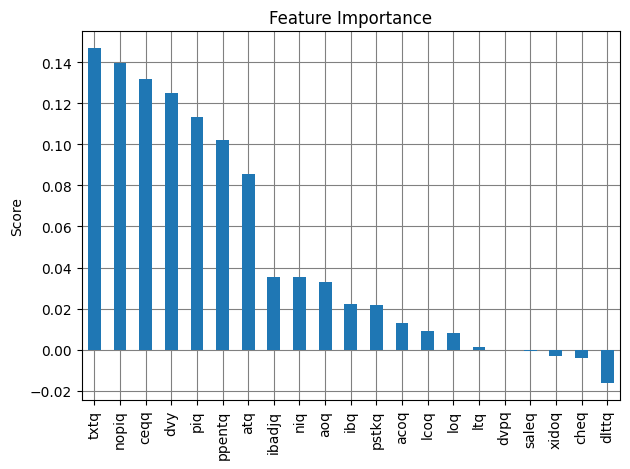

In [378]:
nn4 = nn4_importances_1 /(nn4_importances_1.sum())
fig, ax4 = plt.subplots()
nn4.plot.bar(ax=ax4)
ax4.set_axisbelow(True)
ax4.grid(color='gray')
ax4.set_title('Feature Importance')
ax4.set_ylabel('Score')
fig.tight_layout()
plt.show()

## 7. NN5 Model for Fair Value Estimation

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

df_NN5_Quintile_Signal = pd.DataFrame(index=list_company)
df_NN5_Decile_Signal = pd.DataFrame(index=list_company)
df_NN5_20_Divided_Signal = pd.DataFrame(index=list_company)
df_NN5_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # Baseline NN5 model
    model_nn5 = Sequential()
    model_nn5.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001), input_shape=(21,)))  # Input layer
    model_nn5.add(Dropout(0.4))
    model_nn5.add(Dense(13, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))  # hidden layer 1
    model_nn5.add(Dropout(0.1))
    model_nn5.add(Dense(19, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))  # hidden layer 2
    model_nn5.add(Dropout(0.2))
    model_nn5.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))  # hidden layer 3
    model_nn5.add(Dropout(0.5))
    model_nn5.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))  # hidden layer 4
    model_nn5.add(Dropout(0.6))
    model_nn5.add(Dense(9, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))  # hidden layer 4
    model_nn5.add(Dropout(0.1))
    model_nn5.add(Dense(1, activation='linear'))  # Output layer
    model_nn5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i + 7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i + 6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i + 6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn5.fit(X_train, y_train, epochs=6, callbacks=[callback])
    y_fair = model_nn5.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_NN5_Quintile_Signal = df_NN5_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_NN5_Decile_Signal = df_NN5_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_NN5_20_Divided_Signal = df_NN5_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_NN5_Percentile_Signal = df_NN5_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

### (1) Performance Analysis

In [39]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_NN5_Quintile_Signal = pd.concat([df_199804_199809, df_NN5_Quintile_Signal, df_202206], axis=1)
df_NN5_Quintile_Signal = df_NN5_Quintile_Signal.fillna(0).T
df_NN5_Quintile_Signal = df_NN5_Quintile_Signal.shift(1).dropna()

df_NN5_Decile_Signal = pd.concat([df_199804_199809, df_NN5_Decile_Signal, df_202206], axis=1)
df_NN5_Decile_Signal = df_NN5_Decile_Signal.fillna(0).T
df_NN5_Decile_Signal = df_NN5_Decile_Signal.shift(1).dropna()

df_NN5_20_Divided_Signal = pd.concat([df_199804_199809, df_NN5_20_Divided_Signal, df_202206], axis=1)
df_NN5_20_Divided_Signal = df_NN5_20_Divided_Signal.fillna(0).T
df_NN5_20_Divided_Signal = df_NN5_20_Divided_Signal.shift(1).dropna()

df_NN5_Percentile_Signal = pd.concat([df_199804_199809, df_NN5_Percentile_Signal, df_202206], axis=1)
df_NN5_Percentile_Signal = df_NN5_Percentile_Signal.fillna(0).T
df_NN5_Percentile_Signal = df_NN5_Percentile_Signal.shift(1).dropna()

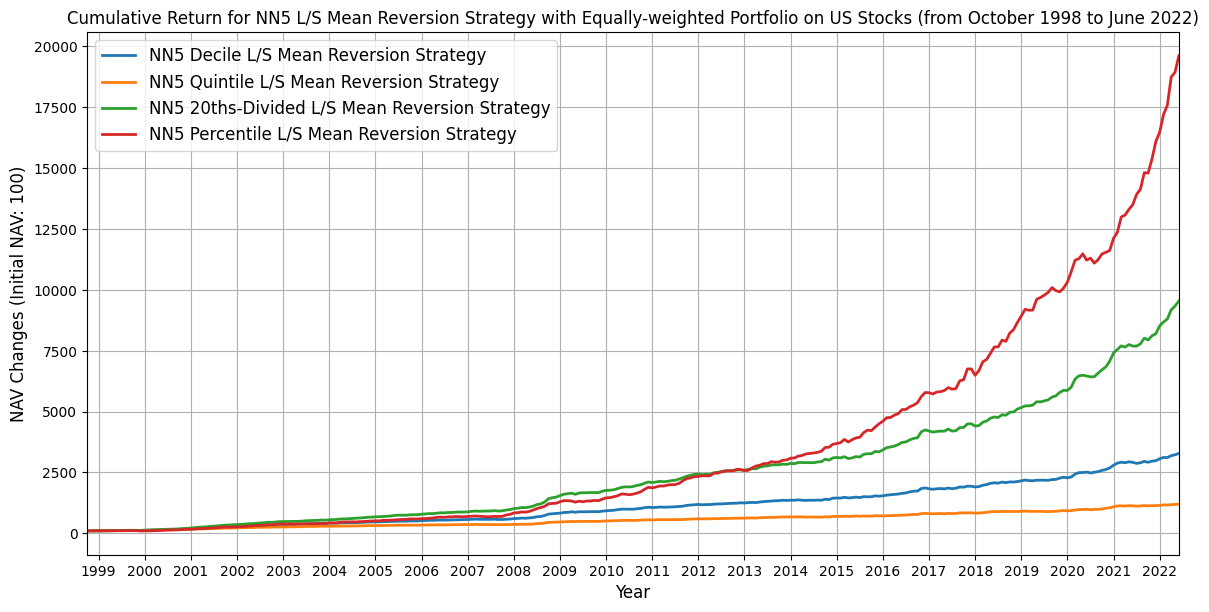

In [165]:
cum_NN5_Q_strategy_return = get_price_df(df_NN5_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_NN5_D_strategy_return = get_price_df(df_NN5_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_NN5_T_strategy_return = get_price_df(df_NN5_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_NN5_P_strategy_return = get_price_df(df_NN5_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_NN5_strategy_return = pd.concat([cum_NN5_D_strategy_return.rename('NN5 Decile L/S Mean Reversion Strategy'),
                                     cum_NN5_Q_strategy_return.rename('NN5 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN5_T_strategy_return.rename('NN5 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_NN5_P_strategy_return.rename('NN5 Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_NN5_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for NN5 L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)', fontsize=12)
plt.show()

In [230]:
# Performance Stats
stats_NN5_Q = get_performance_stats(cum_NN5_Q_strategy_return, rfr=risk_free_rate_df, label='NN5 Quintile (Initial NAV: 100)')
stats_NN5_D = get_performance_stats(cum_NN5_D_strategy_return, rfr=risk_free_rate_df, label='NN5 Decile (Initial NAV: 100)')
stats_NN5_T = get_performance_stats(cum_NN5_T_strategy_return, rfr=risk_free_rate_df, label='NN5 20ths (Initial NAV: 100)')
stats_NN5_P = get_performance_stats(cum_NN5_P_strategy_return, rfr=risk_free_rate_df, label='NN5 Percentile (Initial NAV: 100)')
NN5_stats = pd.concat([stats_NN5_Q, stats_NN5_D, stats_NN5_T, stats_NN5_P], axis=0)
display(NN5_stats)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN5 Quintile (Initial NAV: 100),11.249372,0.111259,0.018682,0.047883,1.933376,0.724075,0.742007,1224.937178,2022-06-30,0.023069,2019-02-28,2019-08-31,2019-11-30,275
NN5 Decile (Initial NAV: 100),33.355523,0.160576,0.018682,0.057318,2.475529,0.870641,1.639022,3435.552320,2022-06-30,0.024766,2021-05-31,2021-07-31,2021-09-30,122
NN5 20ths (Initial NAV: 100),103.512981,0.216236,0.018682,0.067420,2.930192,0.699165,1.496961,10451.298076,2022-06-30,0.032341,2016-12-31,2017-02-28,2017-06-30,181
NN5 Percentile (Initial NAV: 100),226.601904,0.256752,0.018682,0.087374,2.724709,0.121578,1.411404,22760.190381,2022-06-30,0.048935,2017-11-30,2018-01-31,2018-03-31,121


In [231]:
stats2_NN5_Q = get_performance_stats_2(df_NN5_Quintile_Signal, df_returns, df_market_cap, label='NN5 Quintile', model_type='ML')
stats2_NN5_D = get_performance_stats_2(df_NN5_Decile_Signal, df_returns, df_market_cap, label='NN5 Decile', model_type='ML')
stats2_NN5_T = get_performance_stats_2(df_NN5_20_Divided_Signal, df_returns, df_market_cap, label='NN5 20ths', model_type='ML')
stats2_NN5_P = get_performance_stats_2(df_NN5_Percentile_Signal, df_returns, df_market_cap, label='NN5 Percentile', model_type='ML')
NN5_stats2 = pd.concat([stats2_NN5_Q, stats2_NN5_D, stats2_NN5_T, stats2_NN5_P], axis=0)
display(NN5_stats2)

,Total Return,Avg Monthly Return,Avg Mkt Cap,Fraction>0,+ Return Stocks (Avg),- Return Stocks (Avg),Odds Ratio,Odds Ratio 98-10,Odds Ratio 11-22,Transactions/Month
NN5 Quintile (Long & Short),11.249372,0.008830,3.867094e+10,0.713793,0.090593,-0.075890,0.506355,0.521196,0.493866,270.717241
(Long Position),1234.259767,0.025294,5.682630e+08,0.696552,0.103169,-0.073704,0.568864,0.589249,0.551988,140.137931
(Short Position),-0.937405,-0.009676,7.380599e+10,0.379310,0.062310,-0.068434,0.449018,0.459824,0.439789,130.696552
NN5 Decile (Long & Short),33.355523,0.012487,6.726812e+10,0.772414,0.090633,-0.071061,0.519361,0.539189,0.502881,211.065517
(Long Position),9436.197076,0.032635,4.650007e+08,0.758621,0.103724,-0.064157,0.595940,0.628319,0.569836,110.982759
(Short Position),-0.934927,-0.009541,1.256990e+11,0.386207,0.061401,-0.067681,0.452807,0.464102,0.443167,100.093103
NN5 20ths (Long & Short),103.512981,0.016447,1.159337e+11,0.817241,0.091072,-0.066149,0.536517,0.562404,0.515274,147.765517
(Long Position),92779.255636,0.040950,4.482641e+08,0.844828,0.103764,-0.050836,0.641992,0.694277,0.601103,84.468966
(Short Position),-0.940053,-0.009826,2.094126e+11,0.400000,0.061652,-0.067844,0.451640,0.461229,0.443463,63.303448
NN5 Percentile (Long & Short),226.601904,0.019227,3.875807e+11,0.775862,0.089256,-0.069326,0.589778,0.605377,0.576559,47.386207


In [55]:
cum_NN5_Q_strategy_return_L = get_price_df(df_NN5_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN5_Q_strategy_return_S = get_price_df(df_NN5_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_NN5_D_strategy_return_L = get_price_df(df_NN5_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN5_D_strategy_return_S = get_price_df(df_NN5_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_NN5_Q_L = get_performance_stats(cum_NN5_Q_strategy_return_L, rfr=risk_free_rate_df, label='NN5 Quintile L (Initial NAV: 100)')
stats_NN5_Q_S = get_performance_stats(cum_NN5_Q_strategy_return_S, rfr=risk_free_rate_df, label='NN5 Quintile S (Initial NAV: 100)')
stats_NN5_D_L = get_performance_stats(cum_NN5_D_strategy_return_L, rfr=risk_free_rate_df, label='NN5 Decile L (Initial NAV: 100)')
stats_NN5_D_S = get_performance_stats(cum_NN5_D_strategy_return_S, rfr=risk_free_rate_df, label='NN5 Decile S (Initial NAV: 100)')
NN5_stats3 = pd.concat([stats_NN5_Q_L, stats_NN5_Q_S, stats_NN5_D_L, stats_NN5_D_S], axis=0)
display(NN5_stats3)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN5 Quintile L (Initial NAV: 100),1226.724568,0.349172,0.018682,0.168251,1.964266,0.363010,0.609937,139730.710008,2021-10-31,0.121364,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN5 Quintile S (Initial NAV: 100),7.628569,0.094984,0.018682,0.163599,0.466396,-0.561379,1.296159,1109.648153,2021-10-31,0.222405,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN5 Decile L (Initial NAV: 100),8855.006874,0.466221,0.018682,0.154783,2.891391,0.711811,1.266014,950094.228398,2022-03-31,0.067881,2022-03-31,2022-06-30,Yet to recover,Yet to recover
NN5 Decile S (Initial NAV: 100),6.839934,0.090574,0.018682,0.168064,0.427765,-0.480275,1.391595,1053.817951,2021-10-31,0.256045,2021-10-31,2022-06-30,Yet to recover,Yet to recover


### (2) Hyperparameters Tuning

In [ ]:
validation_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]

X_temp = X[X.datadate.isin(validation_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_validation = X_norm[X_norm.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]

y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [403]:
def creating_nn5(hp):
    model = Sequential()

    unit1 = hp.Int('Input_layer', min_value=1, max_value=21, step=1)
    unit2 = hp.Int('lay1', min_value=1, max_value=21, step=1)
    unit3 = hp.Int('lay2', min_value=1, max_value=21, step=1)
    unit4 = hp.Int('lay3', min_value=1, max_value=21, step=1)
    unit11 = hp.Int('lay4', min_value=1, max_value=21, step=1)
    unit13 = hp.Int('lay5', min_value=1, max_value=21, step=1)
    unit5 = hp.Float('dropout1', min_value=0, max_value=0.7, step=0.1)
    unit6 = hp.Float('dropout2', min_value=0, max_value=0.7, step=0.1)
    unit7 = hp.Float('dropout3', min_value=0, max_value=0.7, step=0.1)
    unit8 = hp.Float('dropout4', min_value=0, max_value=0.7, step=0.1)
    unit12 = hp.Float('dropout5', min_value=0, max_value=0.7, step=0.1)
    unit14 = hp.Float('dropout6', min_value=0, max_value=0.7, step=0.1)
    unit9 = hp.Choice('regularization', values=[1e-1, 1e-2, 1e-3])
    unit10 = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')
    learning_rate1 = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

    model.add(Dense(unit1, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9), input_shape=(21,)))
    model.add(Dropout(unit5))
    model.add(Dense(unit2, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit6))
    model.add(Dense(unit3, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit7))
    model.add(Dense(unit4, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit8))
    model.add(Dense(unit11, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit12))
    model.add(Dense(unit13, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit14))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate1), loss='mse', metrics=['mae'])

    return model

In [ ]:
tuner_nn5 = kt.Hyperband(creating_nn5, objective='val_loss', max_epochs=50, project_name='nn5_tuning_1', overwrite=True)
tuner_nn5.search(X_validation, y_validation, epochs=50, validation_data=(X_validation, y_validation), callbacks=[callback], batch_size=32)

In [ ]:
tuner_nn5.results_summary()

In [ ]:
"""
Hyperparameters:
Input_layer: 4
lay1: 13
lay2: 19
lay3: 2
lay4: 16
lay5: 9
dropout1: 0.4
dropout2: 0.1
dropout3: 0.2
dropout4: 0.5
dropout5: 0.6
dropout6: 0.1
regularization: 0.001
dense_activation: relu
learning_rate: 0.01
tuner/epochs: 6
"""

### (3) Feature Importance

In [ ]:
model_nn5 = Sequential()
model_nn5.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001), input_shape=(21,))) # Input layer
model_nn5.add(Dropout(0.4))
model_nn5.add(Dense(13, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 1
model_nn5.add(Dropout(0.1))
model_nn5.add(Dense(19, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 2
model_nn5.add(Dropout(0.2))
model_nn5.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 3
model_nn5.add(Dropout(0.5))
model_nn5.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 4
model_nn5.add(Dropout(0.6))
model_nn5.add(Dense(9, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 4
model_nn5.add(Dropout(0.1))
model_nn5.add(Dense(1, activation='linear')) # Output layer
model_nn5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

temp_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10']
train_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']
test_date = ['1998-10']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

X_temp = X[X.datadate.isin(temp_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_train = X_norm[X_norm.datadate.isin(train_date)]
X_train = X_train.iloc[:, 2:]
X_train = np.array(X_train)

y_train = y[y.datadate.isin(train_date)]
y_train = y_train.iloc[:, 2]
y_train = np.array(y_train)

X_test = X_norm[X_norm.datadate.isin(test_date)]
X_test = X_test.iloc[:, 2:]
X_test = np.array(X_test)

y_test = y[y.datadate.isin(test_date)]
y_test = y_test.iloc[:, 2]
y_test = np.array(y_test)

model_nn5.fit(X_train, y_train)

perm_nn5 = PermutationImportance(model_nn5, scoring='neg_mean_squared_error', random_state=random_state).fit(X_test, y_test)
nn5_importances_1 = pd.Series(perm_nn5.feature_importances_, index=feature_names).sort_values(ascending=False)

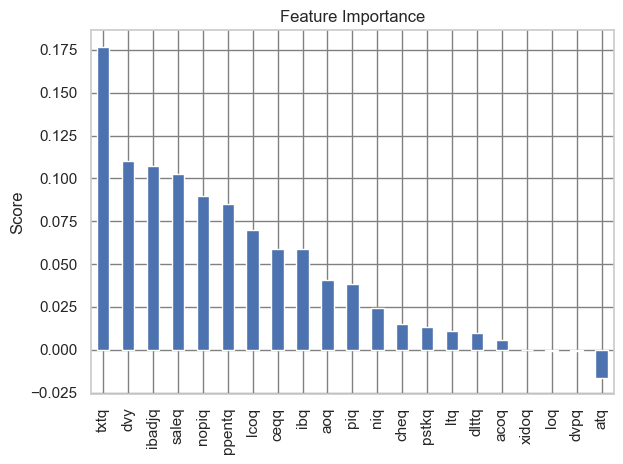

In [20]:
nn5 = nn5_importances_1 /(nn5_importances_1.sum())
fig, ax4 = plt.subplots()
nn5.plot.bar(ax=ax4)
ax4.set_axisbelow(True)
ax4.grid(color='gray')
ax4.set_title('Feature Importance')
ax4.set_ylabel('Score')
fig.tight_layout()
plt.show()

## 8. NN6 Model for Fair Value Estimation

In [ ]:
"""
Hyperparameters:
Input_layer: 12
lay1: 16
lay2: 11
lay3: 11
lay4: 18
lay5: 3
lay6: 18
dropout1: 0.0
dropout2: 0.6
dropout3: 0.6
dropout4: 0.1
dropout5: 0.6
dropout6: 0.0
dropout7: 0.6
regularization: 0.01
dense_activation: relu
learning_rate: 0.001
tuner/epochs: 6
"""

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

df_NN6_Quintile_Signal = pd.DataFrame(index=list_company)
df_NN6_Decile_Signal = pd.DataFrame(index=list_company)
df_NN6_20_Divided_Signal = pd.DataFrame(index=list_company)
df_NN6_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # Baseline NN6 model
    model_nn6 = Sequential()
    model_nn6.add(Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), input_shape=(21,)))  # Input layer
    model_nn6.add(Dropout(0))
    model_nn6.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))  # hidden layer 1
    model_nn6.add(Dropout(0.6))
    model_nn6.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))  # hidden layer 2
    model_nn6.add(Dropout(0.6))
    model_nn6.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))  # hidden layer 3
    model_nn6.add(Dropout(0.1))
    model_nn6.add(Dense(18, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))  # hidden layer 4
    model_nn6.add(Dropout(0.6))
    model_nn6.add(Dense(3, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))  # hidden layer 4
    model_nn6.add(Dropout(0))
    model_nn6.add(Dense(18, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))  # hidden layer 4
    model_nn6.add(Dropout(0.6))
    model_nn6.add(Dense(1, activation='linear'))  # Output layer
    model_nn6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i + 7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i + 6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i + 6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn6.fit(X_train, y_train, epochs=6, callbacks=[callback])
    y_fair = model_nn6.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_NN6_Quintile_Signal = df_NN6_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_NN6_Decile_Signal = df_NN6_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_NN6_20_Divided_Signal = df_NN6_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_NN6_Percentile_Signal = df_NN6_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

### (1) Performance Analysis

In [42]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_NN6_Quintile_Signal = pd.concat([df_199804_199809, df_NN6_Quintile_Signal, df_202206], axis=1)
df_NN6_Quintile_Signal = df_NN6_Quintile_Signal.fillna(0).T
df_NN6_Quintile_Signal = df_NN6_Quintile_Signal.shift(1).dropna()

df_NN6_Decile_Signal = pd.concat([df_199804_199809, df_NN6_Decile_Signal, df_202206], axis=1)
df_NN6_Decile_Signal = df_NN6_Decile_Signal.fillna(0).T
df_NN6_Decile_Signal = df_NN6_Decile_Signal.shift(1).dropna()

df_NN6_20_Divided_Signal = pd.concat([df_199804_199809, df_NN6_20_Divided_Signal, df_202206], axis=1)
df_NN6_20_Divided_Signal = df_NN6_20_Divided_Signal.fillna(0).T
df_NN6_20_Divided_Signal = df_NN6_20_Divided_Signal.shift(1).dropna()

df_NN6_Percentile_Signal = pd.concat([df_199804_199809, df_NN6_Percentile_Signal, df_202206], axis=1)
df_NN6_Percentile_Signal = df_NN6_Percentile_Signal.fillna(0).T
df_NN6_Percentile_Signal = df_NN6_Percentile_Signal.shift(1).dropna()

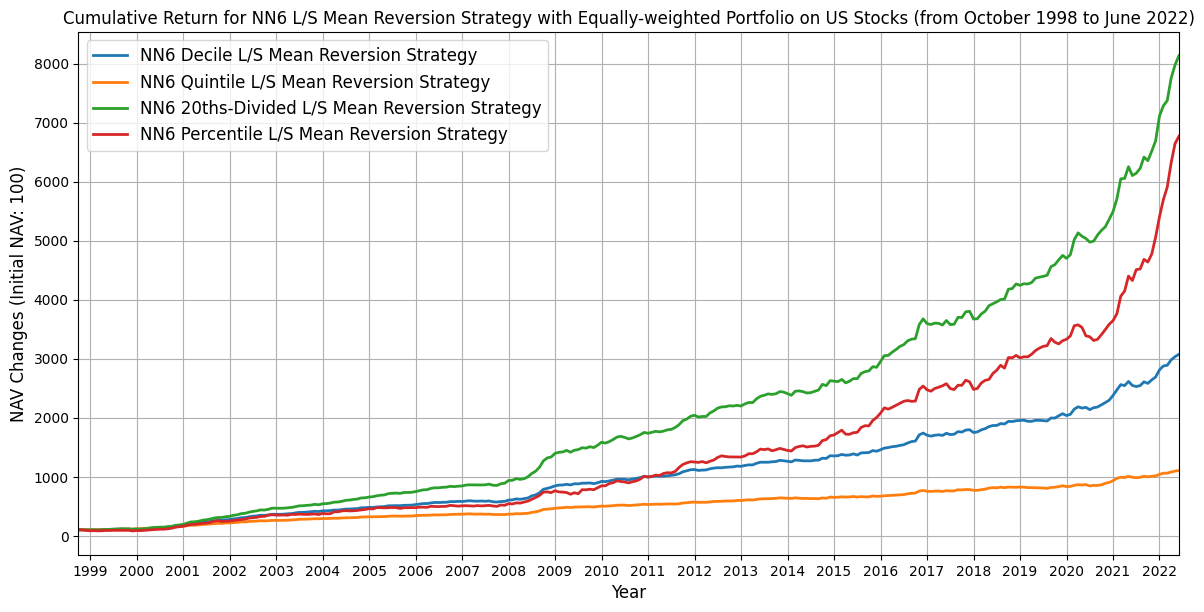

In [190]:
cum_NN6_Q_strategy_return = get_price_df(df_NN6_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_NN6_D_strategy_return = get_price_df(df_NN6_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_NN6_T_strategy_return = get_price_df(df_NN6_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_NN6_P_strategy_return = get_price_df(df_NN6_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_NN6_strategy_return = pd.concat([cum_NN6_D_strategy_return.rename('NN6 Decile L/S Mean Reversion Strategy'),
                                     cum_NN6_Q_strategy_return.rename('NN6 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN6_T_strategy_return.rename('NN6 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_NN6_P_strategy_return.rename('NN6 Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_NN6_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for NN6 L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)', fontsize=12)
plt.show()

In [232]:
# Performance Stats
stats_NN6_Q = get_performance_stats(cum_NN6_Q_strategy_return, rfr=risk_free_rate_df, label='NN6 Quintile (Initial NAV: 100)')
stats_NN6_D = get_performance_stats(cum_NN6_D_strategy_return, rfr=risk_free_rate_df, label='NN6 Decile (Initial NAV: 100)')
stats_NN6_T = get_performance_stats(cum_NN6_T_strategy_return, rfr=risk_free_rate_df, label='NN6 20ths (Initial NAV: 100)')
stats_NN6_P = get_performance_stats(cum_NN6_P_strategy_return, rfr=risk_free_rate_df, label='NN6 Percentile (Initial NAV: 100)')
NN6_stats = pd.concat([stats_NN6_Q, stats_NN6_D, stats_NN6_T, stats_NN6_P], axis=0)
display(NN6_stats)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN6 Quintile (Initial NAV: 100),10.397811,0.107893,0.018682,0.048714,1.831318,0.835081,1.105527,1139.781067,2022-06-30,0.026024,2020-04-30,2020-07-31,2020-11-30,214
NN6 Decile (Initial NAV: 100),29.363385,0.154555,0.018682,0.062840,2.162212,1.105857,2.460501,3036.338456,2022-06-30,0.027412,2021-05-31,2021-07-31,2021-09-30,122
NN6 20ths (Initial NAV: 100),81.700114,0.204307,0.018682,0.077153,2.405934,1.069353,3.005415,8270.011381,2022-06-30,0.036813,2020-04-30,2020-08-31,2020-10-31,184
NN6 Percentile (Initial NAV: 100),76.991437,0.201338,0.018682,0.102170,1.787750,0.198372,2.733569,7799.143664,2022-06-30,0.086608,2016-12-31,2018-02-28,2018-08-31,608


In [44]:
stats2_NN6_Q = get_performance_stats_2(df_NN6_Quintile_Signal, df_returns, df_market_cap, label='NN6 Quintile', model_type='ML')
stats2_NN6_D = get_performance_stats_2(df_NN6_Decile_Signal, df_returns, df_market_cap, label='NN6 Decile', model_type='ML')
stats2_NN6_T = get_performance_stats_2(df_NN6_20_Divided_Signal, df_returns, df_market_cap, label='NN6 20ths', model_type='ML')
stats2_NN6_P = get_performance_stats_2(df_NN6_Percentile_Signal, df_returns, df_market_cap, label='NN6 Percentile', model_type='ML')
NN6_stats2 = pd.concat([stats2_NN6_Q, stats2_NN6_D, stats2_NN6_T, stats2_NN6_P], axis=0)
display(NN6_stats2)

,Total Return,Avg Monthly Return,Avg Mkt Cap,Fraction>0,+ Return Stocks (Avg),- Return Stocks (Avg),Odds Ratio,Odds Ratio 98-10,Odds Ratio 11-22,Transactions/Month
NN6 Quintile (Long & Short),10.049977,0.008465,3.439555e+10,0.710345,0.092487,-0.078727,0.507694,0.520449,0.496958,295.479310
(Long Position),1212.926721,0.025231,9.260438e+08,0.693103,0.102660,-0.073216,0.568822,0.588790,0.552291,157.696552
(Short Position),-0.950523,-0.010493,6.526417e+10,0.393103,0.066588,-0.073637,0.451536,0.458737,0.445382,138.096552
NN6 Decile (Long & Short),29.727380,0.012091,5.804417e+10,0.748276,0.093942,-0.076178,0.521963,0.539638,0.507266,206.675862
(Long Position),9266.447389,0.032569,7.117526e+08,0.758621,0.103650,-0.064140,0.595626,0.626783,0.570493,118.127586
(Short Position),-0.950554,-0.010495,1.082464e+11,0.386207,0.068607,-0.076026,0.457747,0.465990,0.450710,88.603448
NN6 20ths (Long & Short),80.325080,0.015553,1.008934e+11,0.775862,0.095604,-0.074356,0.540946,0.561434,0.524093,136.824138
(Long Position),81149.446057,0.040460,7.356939e+08,0.844828,0.104103,-0.052620,0.640199,0.688878,0.601869,88.324138
(Short Position),-0.963691,-0.011567,1.825929e+11,0.379310,0.070521,-0.079535,0.460397,0.462409,0.458683,48.524138
NN6 Percentile (Long & Short),66.676883,0.014898,3.494678e+11,0.662069,0.094165,-0.081411,0.569344,0.572651,0.566543,39.455172


In [56]:
cum_NN6_Q_strategy_return_L = get_price_df(df_NN6_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN6_Q_strategy_return_S = get_price_df(df_NN6_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_NN6_D_strategy_return_L = get_price_df(df_NN6_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN6_D_strategy_return_S = get_price_df(df_NN6_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_NN6_Q_L = get_performance_stats(cum_NN6_Q_strategy_return_L, rfr=risk_free_rate_df, label='NN6 Quintile L (Initial NAV: 100)')
stats_NN6_Q_S = get_performance_stats(cum_NN6_Q_strategy_return_S, rfr=risk_free_rate_df, label='NN6 Quintile S (Initial NAV: 100)')
stats_NN6_D_L = get_performance_stats(cum_NN6_D_strategy_return_L, rfr=risk_free_rate_df, label='NN6 Decile L (Initial NAV: 100)')
stats_NN6_D_S = get_performance_stats(cum_NN6_D_strategy_return_S, rfr=risk_free_rate_df, label='NN6 Decile S (Initial NAV: 100)')
NN6_stats3 = pd.concat([stats_NN6_Q_L, stats_NN6_Q_S, stats_NN6_D_L, stats_NN6_D_S], axis=0)
display(NN6_stats3)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN6 Quintile L (Initial NAV: 100),1212.926721,0.348530,0.018682,0.168218,1.960835,0.384873,0.674600,136132.561362,2021-10-31,0.108276,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN6 Quintile S (Initial NAV: 100),8.535106,0.099600,0.018682,0.175128,0.462049,-0.448651,1.067943,1327.874294,2021-10-31,0.281927,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN6 Decile L (Initial NAV: 100),9266.447389,0.469027,0.018682,0.154067,2.923046,0.686887,1.159688,988511.069856,2022-03-31,0.062484,2022-03-31,2022-06-30,Yet to recover,Yet to recover
NN6 Decile S (Initial NAV: 100),7.378462,0.093629,0.018682,0.190106,0.394237,-0.335428,1.535081,1244.106422,2021-10-31,0.326548,2021-10-31,2022-06-30,Yet to recover,Yet to recover


### (2) Hyperparameters Tuning

In [21]:
validation_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]

X_temp = X[X.datadate.isin(validation_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_validation = X_norm[X_norm.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]

y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [25]:
def creating_nn6(hp):
    model = Sequential()

    unit1 = hp.Int('Input_layer', min_value=1, max_value=21, step=1)
    unit2 = hp.Int('lay1', min_value=1, max_value=21, step=1)
    unit3 = hp.Int('lay2', min_value=1, max_value=21, step=1)
    unit4 = hp.Int('lay3', min_value=1, max_value=21, step=1)
    unit11 = hp.Int('lay4', min_value=1, max_value=21, step=1)
    unit13 = hp.Int('lay5', min_value=1, max_value=21, step=1)
    unit15 = hp.Int('lay6', min_value=1, max_value=21, step=1)
    unit5 = hp.Float('dropout1', min_value=0, max_value=0.7, step=0.1)
    unit6 = hp.Float('dropout2', min_value=0, max_value=0.7, step=0.1)
    unit7 = hp.Float('dropout3', min_value=0, max_value=0.7, step=0.1)
    unit8 = hp.Float('dropout4', min_value=0, max_value=0.7, step=0.1)
    unit12 = hp.Float('dropout5', min_value=0, max_value=0.7, step=0.1)
    unit14 = hp.Float('dropout6', min_value=0, max_value=0.7, step=0.1)
    unit16 = hp.Float('dropout7', min_value=0, max_value=0.7, step=0.1)
    unit9 = hp.Choice('regularization', values=[1e-1, 1e-2, 1e-3])
    unit10 = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')
    learning_rate1 = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

    model.add(Dense(unit1, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9), input_shape=(21,)))
    model.add(Dropout(unit5))
    model.add(Dense(unit2, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit6))
    model.add(Dense(unit3, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit7))
    model.add(Dense(unit4, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit8))
    model.add(Dense(unit11, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit12))
    model.add(Dense(unit13, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit14))
    model.add(Dense(unit15, activation=unit10, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit16))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate1), loss='mse', metrics=['mae'])

    return model

In [ ]:
tuner_nn6 = kt.Hyperband(creating_nn6, objective='val_loss', max_epochs=50, project_name='nn6_tuning_1', overwrite=True)
tuner_nn6.search(X_validation, y_validation, epochs=50, validation_data=(X_validation, y_validation), callbacks=[callback], batch_size=32)

In [ ]:
tuner_nn6.results_summary()

In [ ]:
"""
Hyperparameters:
Input_layer: 12
lay1: 16
lay2: 11
lay3: 11
lay4: 18
lay5: 3
lay6: 18
dropout1: 0.0
dropout2: 0.6
dropout3: 0.6
dropout4: 0.1
dropout5: 0.6
dropout6: 0.0
dropout7: 0.6
regularization: 0.01
dense_activation: relu
learning_rate: 0.001
tuner/epochs: 6
"""

### (3) Feature Importance

In [ ]:
model_nn6 = Sequential()
model_nn6.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001), input_shape=(21,))) # Input layer
model_nn6.add(Dropout(0.4))
model_nn6.add(Dense(13, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 1
model_nn6.add(Dropout(0.1))
model_nn6.add(Dense(19, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 2
model_nn6.add(Dropout(0.2))
model_nn6.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 3
model_nn6.add(Dropout(0.5))
model_nn6.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 4
model_nn6.add(Dropout(0.6))
model_nn6.add(Dense(9, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 4
model_nn6.add(Dropout(0.1))
model_nn6.add(Dense(1, activation='linear')) # Output layer
model_nn6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

temp_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10']
train_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']
test_date = ['1998-10']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

X_temp = X[X.datadate.isin(temp_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_train = X_norm[X_norm.datadate.isin(train_date)]
X_train = X_train.iloc[:, 2:]
X_train = np.array(X_train)

y_train = y[y.datadate.isin(train_date)]
y_train = y_train.iloc[:, 2]
y_train = np.array(y_train)

X_test = X_norm[X_norm.datadate.isin(test_date)]
X_test = X_test.iloc[:, 2:]
X_test = np.array(X_test)

y_test = y[y.datadate.isin(test_date)]
y_test = y_test.iloc[:, 2]
y_test = np.array(y_test)

model_nn6.fit(X_train, y_train)

perm_nn6 = PermutationImportance(model_nn6, scoring='neg_mean_squared_error', random_state=random_state).fit(X_test, y_test)
nn6_importances_1 = pd.Series(perm_nn6.feature_importances_, index=feature_names).sort_values(ascending=False)

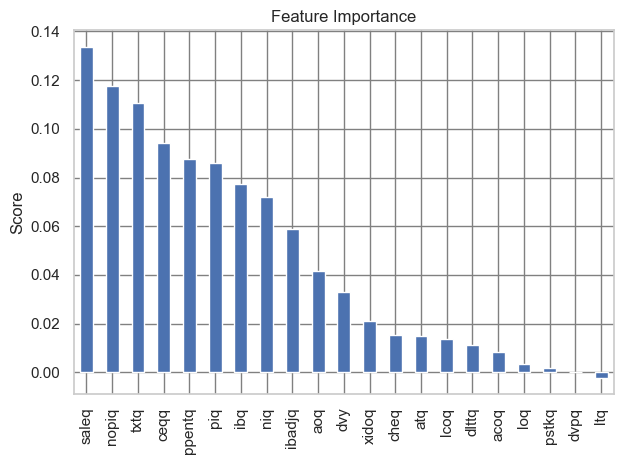

In [17]:
nn6 = nn6_importances_1 /(nn6_importances_1.sum())
fig, ax4 = plt.subplots()
nn6.plot.bar(ax=ax4)
ax4.set_axisbelow(True)
ax4.grid(color='gray')
ax4.set_title('Feature Importance')
ax4.set_ylabel('Score')
fig.tight_layout()
plt.show()